# CAP 4630 Intro to AI
# Project 2 - The Traveling Salesman Problem (TSP) using Genetic Algorithms (GA)
## Contributors: John Kantlehner, Daniel Ramirez, and Brandon Rojas
## Start Date: 06/19/2023
## End Date: 06/21/2023
---

# **Genetic Algorithm**

“Evolution suggests that organisms evolve through reproduction by producing children of mixed genes from their parents. Given the fitness of these individuals in their environment, stronger individuals have a higher likelihood of survival.” (Grokking 91-92).

The Genetic Algorithm (GA) is in the family of evolutionary algorithms and employs its own evolutionary premises.
The GA employs concepts like population, natural selection, fitness, parents, offspring, crossover, and mutation to provide iteratively generated and improved solutions, mimicking the process of evolution.


Cycle of a Genetic Algorithm
1. create population
 * random potential solutions that fit criteria
2. measure fitness of individuals in population
 * determine strength of each solution using a fitness evaluation function
3. select parents based on fitness
 * select parents that will produce offspring for the next generation
4. reproduce individuals from parents
 * create offspring by mixing genes from parents and mutating
5. populate next generation
 * select individuals and offspring that will survive on to the next generation

 A genetic algorithm essentially produces a random population of chromosomes / solutions and evolves each generation, seeking a global best solution within all of the generations. Doing a problem like TSP using brute force would take exceptionally long as its runtime is O(n!).

---

**Starting code**
- https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

---

**How to Run**

---

**!** **Important run all cells prior to the Base Case as skippins cells will cause errors if necessary functions have not been run.**

*   select __Runtime__ in the toolbar at the top of the page
*   choose __Run all__
</br>
OR

*   click __Run cell__ indicated by the 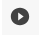 icon next to each code cell







## **Solving the Travelling Salesman Problem using a Genetic Algorithm**

### **Imports**

In [1]:
import numpy as np
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

### **Define City class**

This **City** class allows us to create city objects, calculate the distance between cities and print a string representing the city's coordinates.

In [2]:
# City class
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance

    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"

### **Define Fitness class**
This **Fitness** class is used to calculate and store the distance and fitness of a route.

In [3]:
# Fitness class
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0

    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance

    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

### **Create Population, in this case Routes**

Before we can create our population we define **createRoute()** which creates a random route from our list of cities.

In [4]:
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

The **initialPopulation()** function is what will create our first generation or set of routes.

In [5]:
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

### **Rank based on Fitness**
The **rankRoute()** function is used rank the routes based on the fitness, since a higher fitness is better routes with lower ranks will get ranked towards the end of the list.

Ranking is necessary as it will guide the evolution process using the fittest individuals.


In [6]:
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [7]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Create mating pool

In [8]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

### **Crossover**

Implemented by the function **breed** selects random subsets of cities from parent1 and fills the remaining cities from parent2. Crossover allows the GA to explore new solutions using the characteristics of the parents.

In [9]:
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Create function to run crossover over full mating pool

In [10]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

### **Mutation**
Mutating the population introduces random variations that can help in the search for the best route. Keep in mind increaseing the mutation rate increases the randomness which increases exploration but can have negative affects if too high.

In [11]:
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Create function to run mutation over entire population

In [12]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

Put all steps together to create the next generation

In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

Final step: create the genetic algorithm

In [14]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    best_distance = 1 / rankRoutes(pop)[0][1]  # Store the best distance

    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        current_best_distance = 1 / rankRoutes(pop)[0][1]
        if current_best_distance < best_distance:
            best_distance = current_best_distance  # Update best distance if current is better
            print(f"New best distance of {best_distance} found at generation {i}")
        if i % 20 == 0:  # Every 20 generations
            bestRouteIndex = rankRoutes(pop)[0][0]
            bestRoute = pop[bestRouteIndex]
            current_distance = 1 / Fitness(bestRoute).routeFitness()  # Get current generation's distance
            clear_output(wait=True)
            print("Generation #: " + str(i))
            print("Best distance so far: " + str(best_distance))
            print("Current distance: " + str(current_distance))  # Print current generation's distance
            plot_route(cityList, bestRoute)
            time.sleep(1)

    print("Final best distance: " + str(best_distance))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute

### **Visualization of Routes**

In [17]:
def plot_route(cities, route):
    x = [city.x for city in cities]
    y = [city.y for city in cities]
    plt.figure()
    plt.scatter(x, y, color='blue')
    for i in range(len(route)):
        start_city = route[i]
        end_city = route[(i+1)%len(route)]  # Use modulus to loop back to the start
        plt.plot([start_city.x, end_city.x], [start_city.y, end_city.y], 'r-')
    plt.show()

## Running the genetic algorithm

### **Create list of cities**

In [18]:
cityList = []

for i in range(0,25):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

### **Run GA - Base Case**
We can generate a base case for our optimal route using a Population size of 100, Elite size of 20, Mutation rate of 0.01, and 500 generations

Additional test cases are performed on the city list that was generated. Running cell 19 after a test case will affect results as a new city list with random cities will be generated.

Generation #: 480
Best distance so far: 875.7753124152049
Current distance: 878.4209057272782


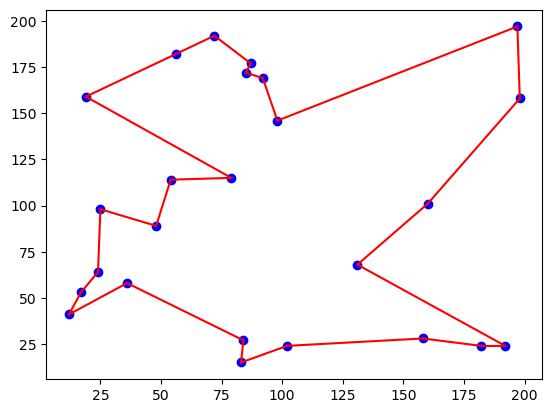

Final best distance: 875.7753124152049


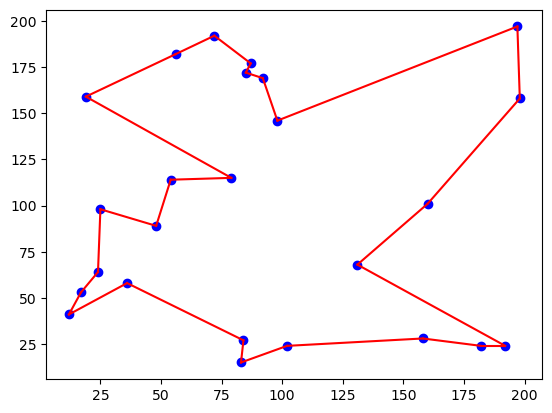

In [21]:
best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=500)
plot_route(cityList, best_route)

### **Test Cases**
Observation notes are documented in the main report although the test cases below

#### **Increase Mutation Rate to 0.05**

In [ ]:
best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.05, generations=500)
plot_route(cityList, best_route)

#### **Change Population Size to 200**

In [ ]:
best_route = geneticAlgorithm(population=cityList, popSize=200, eliteSize=20, mutationRate=0.01, generations=500)
plot_route(cityList, best_route)

#### **Reduce Elite Size to 5**

In [ ]:
best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=5, mutationRate=0.01, generations=500)
plot_route(cityList, best_route)

#### **Reduce Elite Size to 10**

In [ ]:
best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=10, mutationRate=0.01, generations=500)
plot_route(cityList, best_route)

#### **Increase the number of Generations to 1000**


In [ ]:
best_route = geneticAlgorithm(population=cityList, popSize=100, eliteSize=20, mutationRate=0.01, generations=1000)
plot_route(cityList, best_route)